# Fit a very simple logistic growth model to acute infection data

This is to extract growth rates and CrIs to compare with the growth rates of during viral rebound.

In this notebook, we...

1. import the data using `pickle`
2. compile the Stan model
3. convert the data into a format that can be interpreted by the Stan model
4. run the Stan model
5. Extract data and create a figure of the fit
6. Export some of the estimates for use in other notebooks

Many of these operations are quite simple, but require a lot of boilerplate code

**/!\ WARNING /!\** The Stan models use the symbol `r` instead of $g$ for the exponential growth rate.

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pystan
import sys
import scipy.stats as sts
import os

sys.path.append("..")
from mrmpytools import definitions as defn
from mrmpytools import utilities as util
from mrmpytools import plots
from mrmpytools.pystantools import cachedStanModel, calcWAIC, approximate_mode

In [2]:
plt.rcParams.update({'font.size': 18})

## 1. Import the data

The "pickle" is created in the notebook `ParseData.ipynb`.
So **run this notebook first** if you haven't alreasy.

In [3]:
pickle_name = os.path.join("..", "data", "acute-data.pkl")
with open(pickle_name, 'rb') as f:
    data_dicts = pickle.load(f)
    
IDs = sorted(data_dicts.keys())

### Put some of the data in separate dictionaries

In particular, we exclude data points after the start of ART (`StartART`)

In [4]:
txsdict = {}
shorttxsdict = {}
startartdict = {}

for ID in IDs:
    dd = data_dicts[ID]
    txs = [(t, VL, CC) for t, VL, CC in zip(dd["t"], dd["VL"], dd["CC"])]
    txsdict[ID] = txs
    startartdict[ID] = dd["StartART"]
    ## cut off everthing after StartART
    shorttxs = [(t, VL, CC) for (t, VL, CC) in txs if t <= dd["StartART"]]
    shorttxsdict[ID] = shorttxs

## 2. Compile the Stan models

To avoid recompilation, we use the `cachedStanModel` function
imported from `mrmpytools.pystantools`. See also the example in the `pystan`
[documentation](https://pystan.readthedocs.io/en/latest/avoiding_recompilation.html).
The pystan models are pickled and stored in the `stan-models/cache` directory.
We first create this folder if it does not exist.

**This may take some time!** but if you don't change the model, this is only required once.

In [5]:
## make a cache directory for the stan models to avoir re-compiling
cache_dir = os.path.join("..", "stan-models", "cache")
try:
    os.mkdir(cache_dir)
    print("created stan cache directory")
except FileExistsError:
    pass

with open("../stan-models/logistic-acute-model.stan", 'r') as f:
    sm_A = cachedStanModel(model_code=f.read(), work_dir=cache_dir)

Using cached StanModel


## 3. Convert the data into a Stan-readable format

The Stan models have a `data` block listing all the required data.
Currently, these is no rugged data structure in Stan, but all our subjects have a different number of data points. Therefore, we have to apply "padding".

We also define some constants, like the limit of detection for this study, and some values for hyper-parameters. The number of simulated time points `NumSimTimePts` is used to plot trajectories of the logistic growth model for the VL.

Default initial parameter value sampling does not work well for our models. Therefore we supply initial guesses that are more reasonable.

In [6]:
DetectionLimit = 5e1
NumSimTimePts = 100

## make sure that the IDs are sorted by ART init time
IDs.sort(key=lambda x: startartdict[x])

NumTimePts = [len(shorttxsdict[ID]) for ID in IDs]
zpadding = [[0 for _ in range(max(NumTimePts) - n)] for n in NumTimePts]
cpadding = [[defn.missing_code for _ in range(max(NumTimePts) - n)] 
            for n in NumTimePts]

TimePts = [[x[0] for x in shorttxsdict[ID]] + pad 
           for ID, pad in zip(IDs, zpadding)]
VirusLoad = [[x[1] for x in shorttxsdict[ID]] + pad 
             for ID, pad in zip(IDs, zpadding)]
CensorCode = [[x[2] for x in shorttxsdict[ID]] + pad 
              for ID, pad in zip(IDs, cpadding)]

PriorMeanSigma = 0.0
PriorSdSigma = 0.5

data_dict = {
    "NumSubjects" : len(IDs),
    "NumTimePts" : NumTimePts,
    "TimePts" : TimePts,
    "NumSimTimePts" : NumSimTimePts,
    "VirusLoad" : VirusLoad,
    "CensorCode" : CensorCode,
    "StartART" : [startartdict[ID] for ID in IDs], ## currently not used
    "DetectionLimit" : DetectionLimit,
    "PriorMeanSigma" : PriorMeanSigma,
    "PriorSdSigma" : PriorSdSigma,
    "PriorMeanLogK" : 5 * np.log(10),
    "PriorSdLogK" : 2 * np.log(10),
    "PriorMeanLogR" : 0.0,
    "PriorSdLogR" : 1.0,
    "PriorMeanTau" : 1.0,
    "PriorSdTau" : 10.0,
    "MaxR" : 4.0,
}

def gen_init_dict():
    return {
        "logK" : [5 * np.log(10) for _ in IDs],
        "logr" : [0 for _ in IDs],
        "sigma" : PriorMeanSigma + PriorSdSigma,
        "mu_logr" : 0,
        "sigma_logr" : 1.0,
        "mu_logK" : 5 * np.log(10),
        "sigma_logK" : 2 * np.log(10),
        "tau" : [1.0 for _ in IDs],
        "tau_mu" : 1.0,
        "tau_sigma" : 1.0
    }

## 4. Run the Stan model

We have to tweak Stan's algorithmic parameters a bit to avoid divergence of the HMC algorithm.

**This may take some time!**

In [7]:
control_dict = {
    "adapt_delta" : 0.99,
    "max_treedepth" : 20
}

kwargs = {
    "data" : data_dict,
    "init" : gen_init_dict,
    "iter" : 2000, ## 10000
    "chains" : 1, ## 4
    "thin" : 1, ## 20
    "control" : control_dict,
    "refresh" : 10
}

sam_A = sm_A.sampling(**kwargs)
chain = sam_A.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 5. Create a figure of the fit

Just for inspection

CrI: [2.5, 97.5] percentiles


Text(0.5, 0.05, 'time post infection (days)')

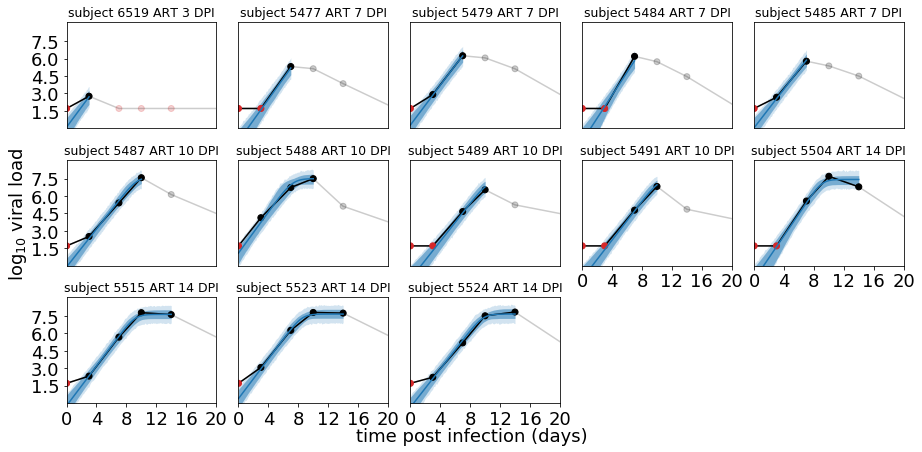

In [8]:
cols = 5
rows = len(IDs) // cols + (0 if len(IDs) % cols == 0 else 1)
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(rows, cols)
gs.update(wspace=0.15, hspace=0.3)

axs = []

plow = 2.5
phigh = 97.5

print("CrI:", [plow, phigh], "percentiles")

for i, ID in enumerate(IDs):
    col = i % cols
    row = i // cols
    ax = fig.add_subplot(gs[row, col])
    axs.append(ax)
    ## plot all rebound data on background
    ts, VLs, CCs = util.unzip(txsdict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k', alpha=0.2)
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=1, alpha=0.2)
    ## plot the data used for fitting on foreground
    ts, VLs, CCs = util.unzip(shorttxsdict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k')
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=2)
    ax.set_title(f"subject {ID} ART {str(startartdict[ID])} DPI", fontsize='x-small')
    ## add model predictions
    logVLhats = chain["logVLhat"][:, i, :].T / np.log(10)
    meanLogVLhats = [np.mean(xs) for xs in logVLhats]
    qsLogVLhats = [np.percentile(xs, [plow, phigh]) for xs in logVLhats]
    logVLsims = chain["logVLsim"][:, i, :].T / np.log(10)
    qsLogVLsims = [np.percentile(xs, [plow, phigh]) for xs in logVLsims]
    tts = np.linspace(0, np.max(ts), NumSimTimePts, endpoint=True)
    ax.plot(tts, meanLogVLhats, color='tab:blue')
    ax.fill_between(tts, [q[0] for q in qsLogVLhats], [q[1] for q in qsLogVLhats], 
                    color='tab:blue', alpha=0.5, linewidth=0)
    ax.fill_between(tts, [q[0] for q in qsLogVLsims], [q[1] for q in qsLogVLsims], 
                    color='tab:blue', alpha=0.2, linewidth=0)
    ax.set_xlim(0, 20)
    ax.set_xticks(range(0, 21, 4))
    ax.set_yticks(np.linspace(1.5, 7.5, 5))
    ## remove repeated axes
    if col > 0:
        ax.get_yaxis().set_visible(False)
    if not i+cols >= len(IDs):
        ax.get_xaxis().set_visible(False)

axs[0].get_shared_y_axes().join(*axs)
axs[0].autoscale(axis='y')
axs[0].set_ylim(0, axs[0].get_ylim()[1])

fig.text(0.07, 0.5, "$\\log_{10}$ viral load", va='center', rotation=90)
fig.text(0.5, 0.05, "time post infection (days)", ha='center')
    
#fig.savefig("../logistic-model-fit-acute.pdf", bbox_inches='tight')

## 6. Export estimates of $g$ for use in Figure 4

The values are stored in another "pickle" in the `data` folder called

> `estimates-acute.pkl`

find posterior modes using Gaussian smoothing

In [9]:
## find posterior modes using Gaussian smoothing

estimate_dicts = {ID : {} for ID in IDs}
    
for i, rs in enumerate(chain["r"].T):
    rmode = approximate_mode(rs)
    Qs = np.percentile(rs, [25, 75])
    pctls = np.percentile(rs, [2.5, 97.5])
    estimate_dicts[IDs[i]]["r_mode"] = rmode
    estimate_dicts[IDs[i]]["r_CrI50"] = Qs
    estimate_dicts[IDs[i]]["r_CrI95"] = pctls
    
## export pickle

estimates_pickle = os.path.join("..", "data", "estimates-acute.pkl")

with open(estimates_pickle, 'wb') as f:
    pickle.dump(estimate_dicts, f)